In [1]:
!pip install torch_optimizer

In [2]:
# !git clone https://github.com/amirgholami/adahessian.git

In [3]:
cd /content/adahessian/image_classification

/content/adahessian/image_classification


In [4]:
import sys
sys.path.append('/content/adahessian/image_classification')  # `adahessian/image_classification` 경로 추가

In [5]:
import os
import time
import csv
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from optim_adahessian import Adahessian  # Import the AdaHessian optimizer


# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Data preparation
def load_data():
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
    return trainloader, testloader


# Optimizers
def optimizer_adahessian(model):
    return Adahessian(model.parameters(), lr=0.001)


def optimizer_hessian_approximation(model):
    class HessianApproximationOptimizer(torch.optim.Optimizer):
        def __init__(self, params, lr=0.001):
            defaults = dict(lr=lr)
            super().__init__(params, defaults)

        def step(self, closure=None):
            loss = closure()
            for group in self.param_groups:
                for param in group['params']:
                    if param.grad is not None:
                        param.grad = param.grad / (1 + torch.abs(param.grad))
                        param.data -= group['lr'] * param.grad

    return HessianApproximationOptimizer(model.parameters(), lr=0.001)


def optimizer_nonlinear_hessian(model):
    class NonlinearHessianOptimizer(torch.optim.Optimizer):
        def __init__(self, params, lr=0.001):
            defaults = dict(lr=lr)
            super().__init__(params, defaults)

        def step(self, closure=None):
            loss = closure()
            for group in self.param_groups:
                for param in group['params']:
                    if param.grad is not None:
                        nonlinear_factor = torch.tanh(param.grad)
                        param.data -= group['lr'] * (param.grad + nonlinear_factor)

    return NonlinearHessianOptimizer(model.parameters(), lr=0.001)


def optimizer_multiscale_hessian(model):
    class MultiScaleHessianOptimizer(torch.optim.Optimizer):
        def __init__(self, params, lr=0.001):
            defaults = dict(lr=lr)
            super().__init__(params, defaults)

        def step(self, closure=None):
            loss = closure()
            for group in self.param_groups:
                for param in group['params']:
                    if param.grad is not None:
                        hessian_scales = torch.abs(param.grad) ** 0.5
                        param.data -= group['lr'] * param.grad / (1 + hessian_scales)

    return MultiScaleHessianOptimizer(model.parameters(), lr=0.001)


def optimizer_hybrid(model):
    class HybridHessianGradientOptimizer(torch.optim.Optimizer):
        def __init__(self, params, lr=0.001):
            defaults = dict(lr=lr)
            super().__init__(params, defaults)

        def step(self, closure=None):
            loss = closure()
            for group in self.param_groups:
                for param in group['params']:
                    if param.grad is not None:
                        grad_update = param.grad
                        hessian_update = torch.autograd.grad(grad_update.sum(), param, retain_graph=True)[0]
                        hybrid_update = 0.5 * grad_update + 0.5 * hessian_update
                        param.data -= group['lr'] * hybrid_update

    return HybridHessianGradientOptimizer(model.parameters(), lr=0.001)


# Training function
def train_model(model, optimizer, criterion, trainloader, testloader, epochs=30, method_name=None, save_path=None):
    train_loss, test_accuracy = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward(create_graph=True)  # Enable Hessian calculations
            optimizer.step(lambda: loss)
            running_loss += loss.item()

        train_loss.append(running_loss / len(trainloader))

        # Evaluate
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy.append(100 * correct / total)
        print(f"[{method_name}] Epoch {epoch+1}/{epochs}, Loss: {train_loss[-1]:.4f}, Accuracy: {test_accuracy[-1]:.2f}%")

    # Save results as CSV
    csv_file = os.path.join(save_path, f"{method_name}.csv")
    with open(csv_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Loss", "Accuracy"])
        for epoch, (loss, accuracy) in enumerate(zip(train_loss, test_accuracy)):
            writer.writerow([epoch + 1, loss, accuracy])

    return train_loss, test_accuracy


# Main function
def main_experiment(selected_methods=None):
    trainloader, testloader = load_data()
    epochs = 30

    # Define all methods
    all_methods = {
        "AdaHessian": optimizer_adahessian,
        "Hessian Approximation": optimizer_hessian_approximation,
        "Nonlinear Hessian": optimizer_nonlinear_hessian,
        "Multi-Scale Hessian": optimizer_multiscale_hessian,
        "Hybrid Hessian-Gradient": optimizer_hybrid
    }

    # Filter selected methods
    methods_to_run = {"AdaHessian": optimizer_adahessian}  # AdaHessian is always included
    for method in selected_methods:
        if method in all_methods:
            methods_to_run[method] = all_methods[method]

    # Create experiment folder
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    experiment_path = f"experiment_{timestamp}"
    os.makedirs(experiment_path, exist_ok=True)

    # Save selected methods as Python files (just in case)
    for method_name, method_fn in methods_to_run.items():
        method_code = globals()[f"optimizer_{method_name.lower().replace(' ', '_')}"].__code__
        method_path = os.path.join(experiment_path, f"{method_name}.py")
        with open(method_path, "w") as f:
            f.write(f"# {method_name}\n")
            f.write("import torch\n\n")
            f.write(method_code.co_consts[0])  # Function code as a string

    # Run experiments
    results = {}
    for method_name, optimizer_fn in methods_to_run.items():
        print(f"Training with {method_name}...")
        model = SimpleCNN().cuda()
        optimizer = optimizer_fn(model)
        criterion = nn.CrossEntropyLoss()
        method_path = os.path.join(experiment_path, method_name)
        os.makedirs(method_path, exist_ok=True)

        # Train and save results
        loss, accuracy = train_model(
            model, optimizer, criterion, trainloader, testloader, epochs, method_name, save_path=method_path
        )
        results[method_name] = {"loss": loss, "accuracy": accuracy}

        # Save the trained model
        torch.save(model.state_dict(), os.path.join(method_path, f"{method_name}_model.pth"))

    # Plot results
    for metric in ['loss', 'accuracy']:
        plt.figure()
        for method, values in results.items():
            plt.plot(range(epochs), values[metric], label=f"{method} {metric.capitalize()}")
        plt.legend()
        plt.title(f"Comparison of {metric.capitalize()}")
        plt.savefig(os.path.join(experiment_path, f"{metric}_comparison.png"))
        plt.close()



Files already downloaded and verified
Files already downloaded and verified
Training with AdaHessian...


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1201.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/30, Loss: 2.1507, Accuracy: 31.52%
Epoch 2/30, Loss: 1.9451, Accuracy: 34.67%
Epoch 3/30, Loss: 1.8610, Accuracy: 37.31%
Epoch 4/30, Loss: 1.8027, Accuracy: 39.52%
Epoch 5/30, Loss: 1.7561, Accuracy: 40.23%
Epoch 6/30, Loss: 1.7259, Accuracy: 41.22%
Epoch 7/30, Loss: 1.6919, Accuracy: 42.63%
Epoch 8/30, Loss: 1.6628, Accuracy: 43.15%
Epoch 9/30, Loss: 1.6433, Accuracy: 44.15%
Epoch 10/30, Loss: 1.6230, Accuracy: 44.62%
Epoch 11/30, Loss: 1.6079, Accuracy: 44.64%
Epoch 12/30, Loss: 1.5892, Accuracy: 45.52%
Epoch 13/30, Loss: 1.5738, Accuracy: 45.59%
Epoch 14/30, Loss: 1.5628, Accuracy: 46.23%
Epoch 15/30, Loss: 1.5528, Accuracy: 46.70%
Epoch 16/30, Loss: 1.5431, Accuracy: 46.93%
Epoch 17/30, Loss: 1.5298, Accuracy: 47.54%
Epoch 18/30, Loss: 1.5246, Accuracy: 47.83%
Epoch 19/30, Loss: 1.5171, Accuracy: 48.62%
Epoch 20/30, Loss: 1.5053, Accuracy: 48.52%
Epoch 21/30, Loss: 1.5001, Accuracy: 48.67%
Epoch 22/30, Loss: 1.4958, Accuracy: 49.32%
Epoch 23/30, Loss: 1.4866, Accuracy: 49.3

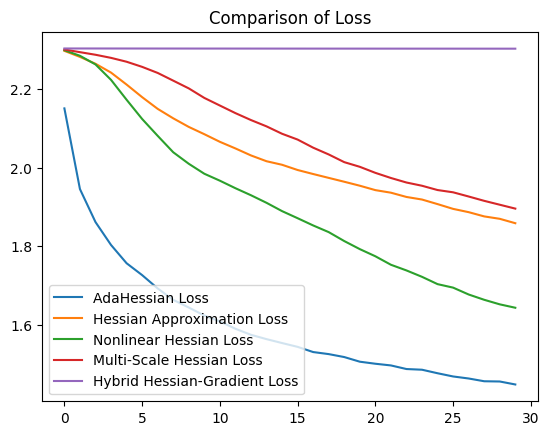

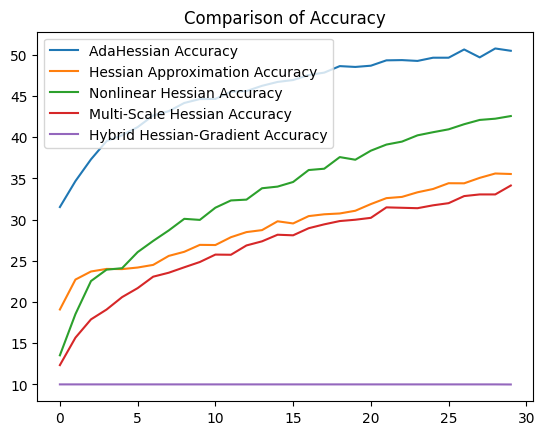

In [6]:
# Example usage

# Select methods to run
# Feel free to modify below. If you are in charge of specific method, then you can put that method only.
# Don't put Adahessian. We run AdaHessian as default.
selected_methods = ["Hessian Approximation", "Nonlinear Hessian", "Multi-Scale Hessian", "Hybrid Hessian-Gradient"]
main_experiment(selected_methods)